In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Average
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
import shutil
from keras.models import Sequential
from keras import layers, models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers.legacy import Adam, SGD, Adamax

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
random_path = '/content/drive/MyDrive/dataset/demo'
list_of_classes=['Healthy', 'Moderate', 'Severe']

In [ ]:
from tensorflow.keras.models import load_model
# Load the best saved model
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/kneeEffNetB5_94.14.h5')
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/DenseNet_93.41.h5')
model3 = load_model('/content/drive/MyDrive/Colab Notebooks/InceptionV3_94.08.h5')
model4 = load_model('/content/drive/MyDrive/Colab Notebooks/MobileNet_93.65.h5')

In [ ]:
model1._name = "model1"
model2._name = "model2"
model3._name = "model3"
model4._name = "model4"

input_tensor = Input(shape=(224, 224, 3))

output_tensor1 = model1(input_tensor)
output_tensor2 = model2(input_tensor)
output_tensor3 = model3(input_tensor)
output_tensor4 = model4(input_tensor)

output_tensor = Average()([output_tensor1, output_tensor2, output_tensor3, output_tensor4])

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/ensemble_model/cp.ckpt"

loaded_model = Model(inputs=input_tensor, outputs=output_tensor)
lr=.001
loaded_model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
loaded_model.load_weights(checkpoint_path)

In [ ]:
file_list = os.listdir(random_path+'/1')
for file_name in file_list:
    file_path = os.path.join(random_path+'/1', file_name)
    os.remove(file_path)



image_path = "/content/1.png"

shutil.copy(image_path, random_path+'/1')

'/content/drive/MyDrive/dataset/demo/1/1.png'

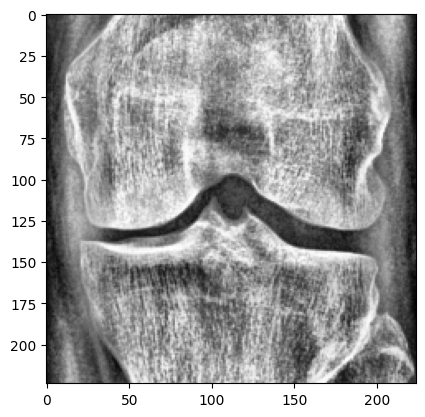

In [ ]:
from PIL import Image
img = Image.open(random_path+'/1/'+'1.png')

# display the image using matplotlib
plt.imshow(img, cmap = plt.cm.gray)
plt.show()

In [ ]:
data_gen = ImageDataGenerator()

# Create a data generator for the image
data_generator = data_gen.flow_from_directory(
    directory=random_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 1 images belonging to 1 classes.


In [ ]:
preds=loaded_model.predict(data_generator, verbose=1)
print("The predicted class the image belongs to  is :",list_of_classes[np.argmax(preds)])

1/1 [==============================] - 11s 11s/step
The predicted class the image belongs to  is : Healthy


In [ ]:
from visualize import random_colors, get_mask_contours, draw_mask
%matplotlib inline
# Load Image
img = cv2.imread("/content/1.png")

test_model, inference_config = load_inference_model(1, "/content/maskrcnn_colab/logs/object20230423T1731/mask_rcnn_object_0001.h5")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Detect results
r = test_model.detect([image])[0]
colors = random_colors(80)

Loading weights from  /content/maskrcnn_colab/logs/object20230423T1731/mask_rcnn_object_0001.h5
Re-starting from epoch 1


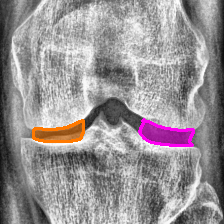

2


In [ ]:
from google.colab.patches import cv2_imshow
# Get Coordinates and show it on the image
object_count = len(r["class_ids"])
setc = []
for i in range(object_count):
    # 1. Mask
    mask = r["masks"][:, :, i]
    contours = get_mask_contours(mask)
    setc.append(contours)
    for cnt in contours:
        cv2.polylines(img, [cnt], True, colors[i], 2)
        img = draw_mask(img, [cnt], colors[i])

cv2_imshow(img)
print(len(setc))

In [ ]:
#print(contours)
centers = []
for i in range(2):
  M = cv2.moments(np.array(setc[i]))
  centroid_x = int(M["m10"] / M["m00"])
  centroid_y = int(M["m01"] / M["m00"])
  centroid = [centroid_x, centroid_y]
  centers.append(centroid)

print(centers)

[[60, 133], [165, 134]]


In [ ]:
distance = 1000
for i in range(2):
  centroid_x = centers[i][0]
  centroid_y = centers[i][1]
  centroid = (centroid_x, centroid_y)

  line_x = centroid_x
  line_y1 = 0
  line_y2 = img.shape[0] - 1
      
  intersection_points = []
  for point in setc[i][0]:
      x, y = point
      if x == line_x:
          intersection_points.append((x, y))
              
  if intersection_points:
      intersection_point = min(intersection_points, key=lambda p: abs(p[1]-centroid_y))
      intersection_point1 = max(intersection_points, key=lambda p: abs(p[1]-centroid_y))

      distance = min(distance, abs(intersection_point1[1] - intersection_point[1]))
          
      cv2.circle(img, intersection_point1, 3, (255,0,0), -1)
      cv2.circle(img, intersection_point, 3, (0,0,255), -1)

The distance between th joint space width is : 4.59 mm


In [ ]:
distance2 = 1000
centers[0][0]+=2
centers[1][0]+=2
for i in range(2):
  centroid_x = centers[i][0]
  centroid_y = centers[i][1]
  centroid = (centroid_x, centroid_y)

  line_x = centroid_x
  line_y1 = 0
  line_y2 = img.shape[0] - 1
      
  intersection_points = []
  for point in setc[i][0]:
      x, y = point
      if x == line_x:
          intersection_points.append((x, y))
              
  if intersection_points:
      intersection_point = min(intersection_points, key=lambda p: abs(p[1]-centroid_y))
      intersection_point1 = max(intersection_points, key=lambda p: abs(p[1]-centroid_y))

      distance2 = min(distance2, abs(intersection_point1[1] - intersection_point[1]))
          
      cv2.circle(img, intersection_point1, 3, (255,0,0), -1)
      cv2.circle(img, intersection_point, 3, (0,0,255), -1)

The distance between the joint space width is : 4.59 mm


The distance between the joint space width is : 4.59 mm


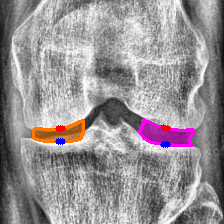

In [ ]:
distance1 = 1000
centers[0][0]-=2
centers[1][0]-=2
for i in range(2):
  centroid_x = centers[i][0]
  centroid_y = centers[i][1]
  centroid = (centroid_x, centroid_y)

  line_x = centroid_x
  line_y1 = 0
  line_y2 = img.shape[0] - 1
      
  intersection_points = []
  for point in setc[i][0]:
      x, y = point
      if x == line_x:
          intersection_points.append((x, y))
              
  if intersection_points:
      intersection_point = min(intersection_points, key=lambda p: abs(p[1]-centroid_y))
      intersection_point1 = max(intersection_points, key=lambda p: abs(p[1]-centroid_y))

      distance1 = min(distance1, abs(intersection_point1[1] - intersection_point[1]))
          
      cv2.circle(img, intersection_point1, 3, (255,0,0), -1)
      cv2.circle(img, intersection_point, 3, (0,0,255), -1)

print("The distance between the joint space width is :",format(((distance1+distance2+distance)/3)*0.353,".2f"),"mm")
cv2_imshow(img)

In [ ]:
if(list_of_classes[np.argmax(preds)]==0):
  print("The image belongs to class ",list_of_classes[np.argmax(preds)]," and the distance is ",format(distance*0.353,".2f"),"mm")
  if((distance*0.353)>=3.5):
    print("The distance for the class moderate is less than 2mm, the condition is not severe for now")
  if(3.5>=(distance*0.353)>=2.0):
    print("The distance for the class moderate is less than 2mm, you should be more careful because you are very close to the moderate stage")

The image belongs to class  Healthy  and the distance is  4.59 mm
The distance for the class moderate is less than 2mm, the condition is not severe for now


In [ ]:
if(list_of_classes[np.argmax(preds)]==1):
  print("The image belongs to class ",list_of_classes[np.argmax(preds)]," and the distance is ",format(distance*0.353,".2f"),"mm")
  if((distance*0.353)>=1.5):
    print("The condition is not severe for now, but precautions should be taken")
  if(1.5>=(distance*0.353)>=0.0):
    print("You should be more careful because you are very close to the going to the final stage")